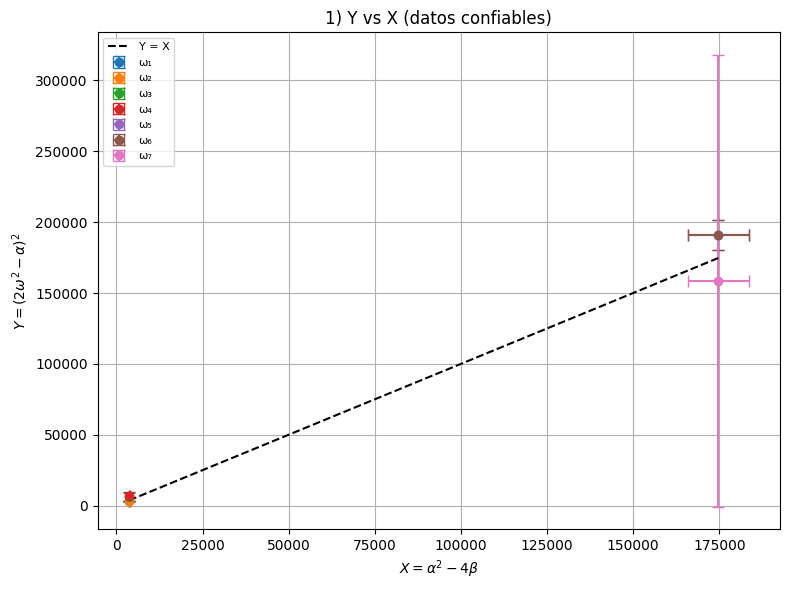

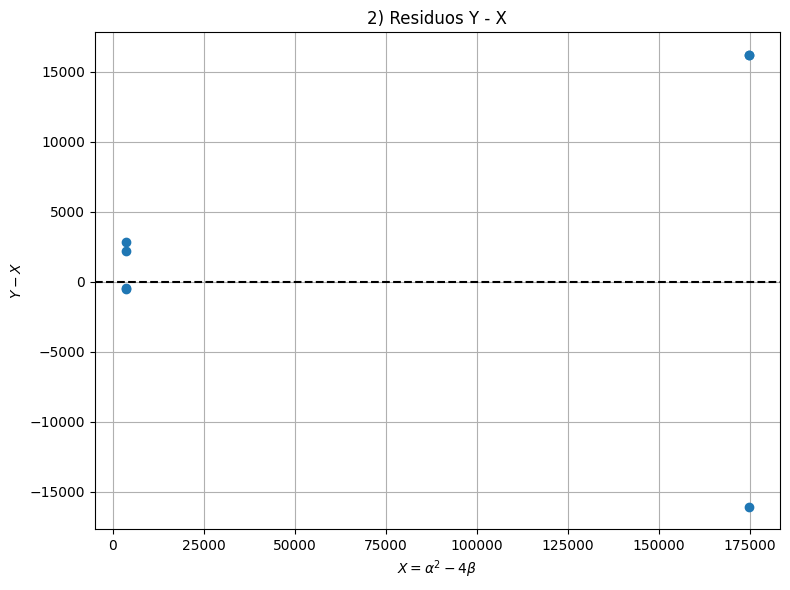

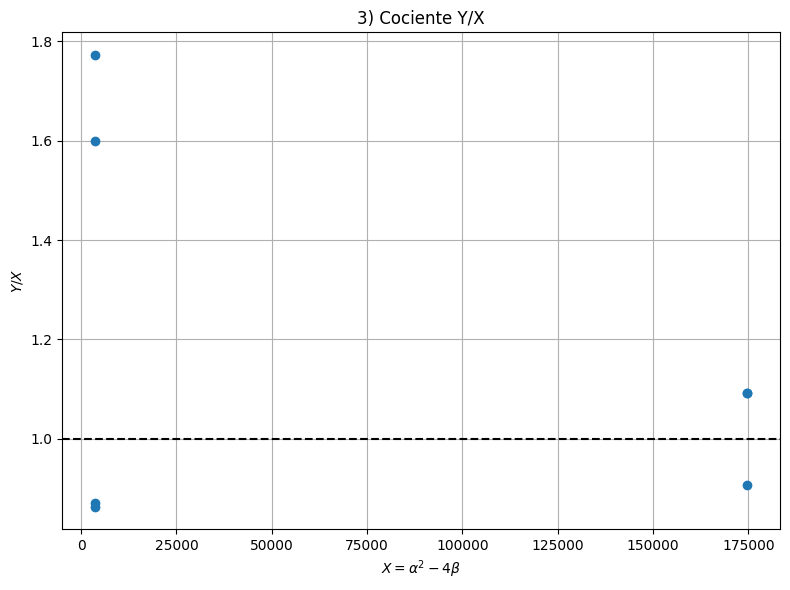

4) Ajuste lineal:
 - Pendiente = 1.0260
 - Intercepto = 917.7095
 - R² = 0.9869


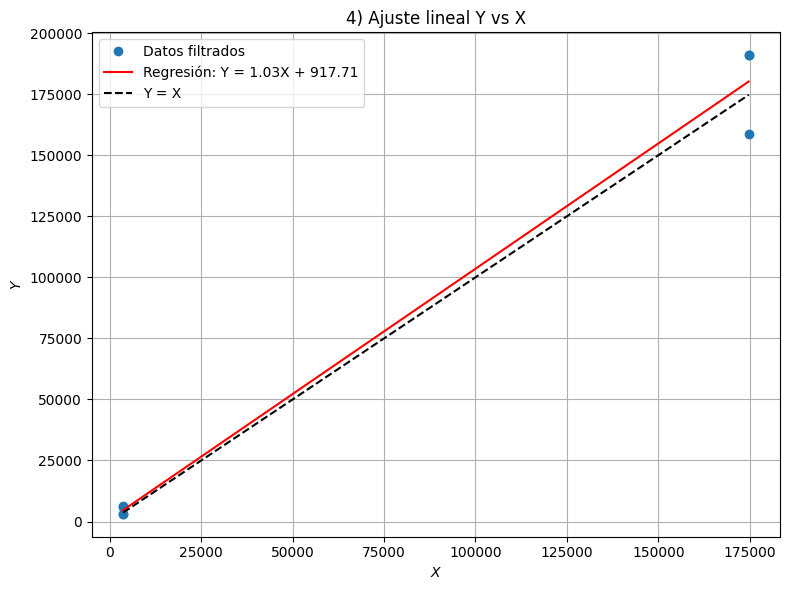

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

# === Leer CSV ===
df = pd.read_csv('frecuencias_con_parametros_final.csv')

# === Filtrar solo los datos experimentales ===
df_exp = df[~df['Índice'].str.contains('teo')].copy()

# === Calcular X, Y y sus errores ===
def calcular_xy(row):
    k1, k2, k3 = row['k₁'], row['k₂'], row['k₃']
    dk1, dk2, dk3 = row['Δk₁'], row['Δk₂'], row['Δk₃']
    m1, m2 = row['m₁'], row['m₂']
    dm1, dm2 = row['Δm₁'], row['Δm₂']
    omega = row['Valor (rad/s)']
    domega = row['Error (rad/s)']

    alpha = (k1 + k2)/m1 + (k2 + k3)/m2
    beta = (k1*k2 + k1*k3 + k2*k3)/(m1*m2)
    omega_sq = omega**2

    d_alpha = np.sqrt(
        (1/m1 * dk1)**2 +
        ((1/m1 + 1/m2) * dk2)**2 +
        (1/m2 * dk3)**2 +
        ((-(k1 + k2) / m1**2) * dm1)**2 +
        ((-(k2 + k3) / m2**2) * dm2)**2
    )

    d_beta = np.sqrt(
        (((k2 + k3) / (m1 * m2)) * dk1)**2 +
        (((k1 + k3) / (m1 * m2)) * dk2)**2 +
        (((k1 + k2) / (m1 * m2)) * dk3)**2 +
        ((-beta / m1) * dm1)**2 +
        ((-beta / m2) * dm2)**2
    )

    X = alpha**2 - 4 * beta
    Y = (2 * omega_sq - alpha)**2

    dX = np.sqrt((2 * alpha * d_alpha)**2 + (4 * d_beta)**2)
    dY = np.sqrt((8 * omega * (2 * omega_sq - alpha) * domega)**2 + (2 * (2 * omega_sq - alpha) * d_alpha)**2)

    return pd.Series({'X': X, 'X_err': dX, 'Y': Y, 'Y_err': dY, 'alpha': alpha, 'beta': beta})

df_exp = df_exp.join(df_exp.apply(calcular_xy, axis=1))

# === Filtro de confianza: errores menores al 10% de ω ===
df_exp['rel_error_omega'] = df_exp['Error (rad/s)'] / df_exp['Valor (rad/s)']
df_filtrada = df_exp[df_exp['rel_error_omega'] < 0.1].copy()

# === Cálculo de residuos ===
df_filtrada['Residuo'] = df_filtrada['Y'] - df_filtrada['X']
df_filtrada['Y_div_X'] = df_filtrada['Y'] / df_filtrada['X']

# === 1) Y vs X con error ===
plt.figure(figsize=(8,6))
for i, (_, row) in enumerate(df_filtrada.iterrows()):
    plt.errorbar(row['X'], row['Y'], xerr=row['X_err'], yerr=row['Y_err'],
                 fmt='o', capsize=4, label=row['Índice'])
xline = np.linspace(df_filtrada['X'].min(), df_filtrada['X'].max(), 100)
plt.plot(xline, xline, 'k--', label='Y = X')
plt.xlabel(r'$X = \alpha^2 - 4\beta$')
plt.ylabel(r'$Y = (2\omega^2 - \alpha)^2$')
plt.title('1) Y vs X (datos confiables)')
plt.legend(fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()

# === 2) Residuos Y - X ===
plt.figure(figsize=(8,6))
plt.axhline(0, color='k', linestyle='--')
plt.errorbar(df_filtrada['X'], df_filtrada['Residuo'], fmt='o')
plt.xlabel(r'$X = \alpha^2 - 4\beta$')
plt.ylabel(r'$Y - X$')
plt.title('2) Residuos Y - X')
plt.grid(True)
plt.tight_layout()
plt.show()

# === 3) Cociente Y / X ===
plt.figure(figsize=(8,6))
plt.axhline(1, color='k', linestyle='--')
plt.plot(df_filtrada['X'], df_filtrada['Y_div_X'], 'o')
plt.xlabel(r'$X = \alpha^2 - 4\beta$')
plt.ylabel(r'$Y / X$')
plt.title('3) Cociente Y/X')
plt.grid(True)
plt.tight_layout()
plt.show()

# === 4) Ajuste lineal Y vs X ===
slope, intercept, r_value, p_value, stderr = linregress(df_filtrada['X'], df_filtrada['Y'])
print(f'4) Ajuste lineal:\n - Pendiente = {slope:.4f}\n - Intercepto = {intercept:.4f}\n - R² = {r_value**2:.4f}')

plt.figure(figsize=(8,6))
plt.plot(df_filtrada['X'], df_filtrada['Y'], 'o', label='Datos filtrados')
plt.plot(xline, slope * xline + intercept, 'r-', label=f'Regresión: Y = {slope:.2f}X + {intercept:.2f}')
plt.plot(xline, xline, 'k--', label='Y = X')
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.title('4) Ajuste lineal Y vs X')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


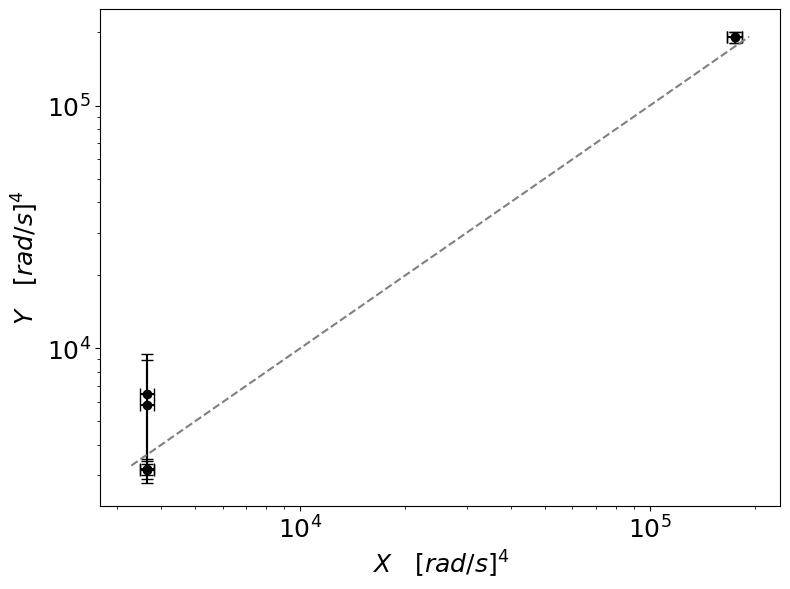

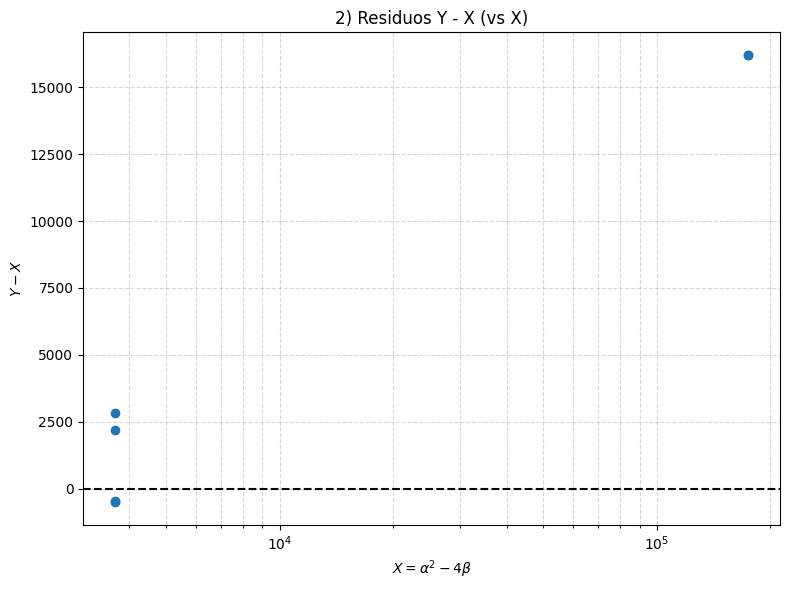

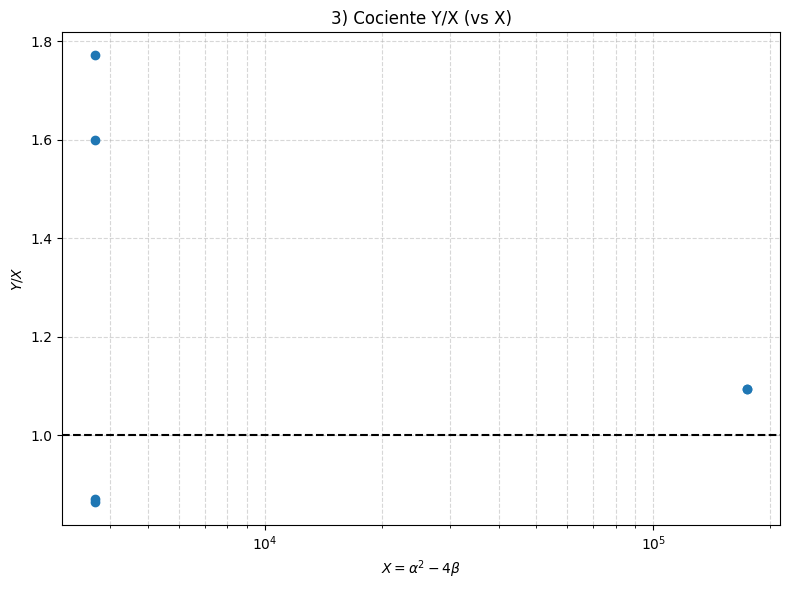

4) Ajuste log-log:
 - Pendiente = 0.9739
 - Intercepto (ln) = 0.4035
 - R² = 0.9770


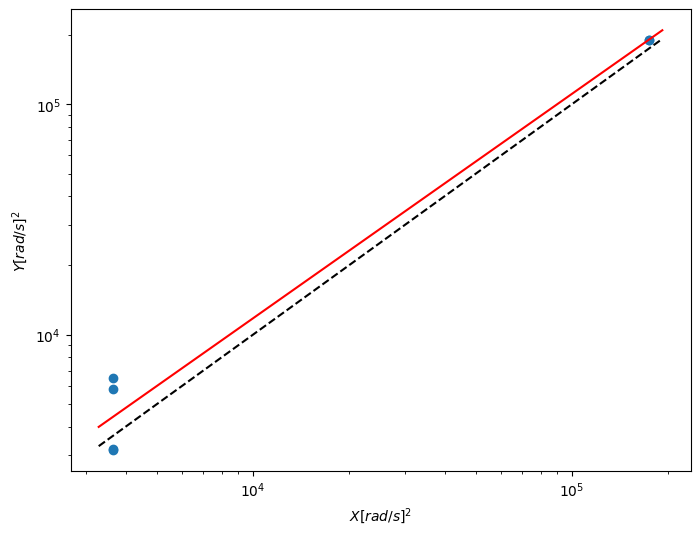

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

# === Leer CSV ===
df = pd.read_csv('frecuencias_con_parametros_final.csv')

# === Filtrar solo los datos experimentales ===
df_exp = df[~df['Índice'].str.contains('teo')].copy()

# === Calcular X, Y y sus errores ===
def calcular_xy(row):
    k1, k2, k3 = row['k₁'], row['k₂'], row['k₃']
    dk1, dk2, dk3 = row['Δk₁'], row['Δk₂'], row['Δk₃']
    m1, m2 = row['m₁'], row['m₂']
    dm1, dm2 = row['Δm₁'], row['Δm₂']
    omega = row['Valor (rad/s)']
    domega = row['Error (rad/s)']

    alpha = (k1 + k2)/m1 + (k2 + k3)/m2
    beta = (k1*k2 + k1*k3 + k2*k3)/(m1*m2)
    omega_sq = omega**2

    d_alpha = np.sqrt(
        (1/m1 * dk1)**2 +
        ((1/m1 + 1/m2) * dk2)**2 +
        (1/m2 * dk3)**2 +
        ((-(k1 + k2) / m1**2) * dm1)**2 +
        ((-(k2 + k3) / m2**2) * dm2)**2
    )

    d_beta = np.sqrt(
        (((k2 + k3) / (m1 * m2)) * dk1)**2 +
        (((k1 + k3) / (m1 * m2)) * dk2)**2 +
        (((k1 + k2) / (m1 * m2)) * dk3)**2 +
        ((-beta / m1) * dm1)**2 +
        ((-beta / m2) * dm2)**2
    )

    X = alpha**2 - 4 * beta
    Y = (2 * omega_sq - alpha)**2

    dX = np.sqrt((2 * alpha * d_alpha)**2 + (4 * d_beta)**2)
    dY = np.sqrt((8 * omega * (2 * omega_sq - alpha) * domega)**2 + (2 * (2 * omega_sq - alpha) * d_alpha)**2)

    return pd.Series({'X': X, 'X_err': dX, 'Y': Y, 'Y_err': dY, 'alpha': alpha, 'beta': beta})

df_exp = df_exp.join(df_exp.apply(calcular_xy, axis=1))

# === Filtro: errores relativos < 10% ===
df_exp['rel_error_omega'] = df_exp['Error (rad/s)'] / df_exp['Valor (rad/s)']
df_filtrada = df_exp[df_exp['rel_error_omega'] < 0.08].copy()

# === Residuos y razón ===
df_filtrada['Residuo'] = df_filtrada['Y'] - df_filtrada['X']
df_filtrada['Y_div_X'] = df_filtrada['Y'] / df_filtrada['X']

# === 1) Y vs X (log-log) ===
plt.figure(figsize=(8,6))

# Puntos en negro
for _, row in df_filtrada.iterrows():
    plt.errorbar(
        row['X'], row['Y'],
        xerr=row['X_err'], yerr=row['Y_err'],
        fmt='o', color='black', ecolor='black', capsize=4,
        label=row['Índice']
    )

# Línea de tendencia Y = X en gris
xline = np.logspace(np.log10(df_filtrada['X'].min()*0.9),
                    np.log10(df_filtrada['X'].max()*1.1), 200)
plt.plot(xline, xline, color='gray', linestyle='--', label='Y = X')

# Escalas y etiquetas
plt.xscale('log')
plt.yscale('log')
FS = 18
plt.xlabel(r'$X \quad [rad/s]^4$', fontsize=FS)
plt.ylabel(r'$Y \quad [rad/s]^4$'  , fontsize=FS)
plt.tick_params(labelsize=FS)
plt.tight_layout()
plt.show()

# === 2) Residuos (lineal) ===
plt.figure(figsize=(8,6))
plt.axhline(0, color='k', linestyle='--')
plt.errorbar(df_filtrada['X'], df_filtrada['Residuo'], fmt='o')
plt.xscale('log')
plt.xlabel(r'$X = \alpha^2 - 4\beta$')
plt.ylabel(r'$Y - X$')
plt.title('2) Residuos Y - X (vs X)')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# === 3) Y / X (lineal) ===
plt.figure(figsize=(8,6))
plt.axhline(1, color='k', linestyle='--')
plt.plot(df_filtrada['X'], df_filtrada['Y_div_X'], 'o')
plt.xscale('log')
plt.xlabel(r'$X = \alpha^2 - 4\beta$')
plt.ylabel(r'$Y / X$')
plt.title('3) Cociente Y/X (vs X)')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# === 4) Ajuste lineal Y vs X (log-log) ===
slope, intercept, r_value, p_value, stderr = linregress(np.log(df_filtrada['X']), np.log(df_filtrada['Y']))
print(f'4) Ajuste log-log:\n - Pendiente = {slope:.4f}\n - Intercepto (ln) = {intercept:.4f}\n - R² = {r_value**2:.4f}')

plt.figure(figsize=(8,6))
plt.plot(df_filtrada['X'], df_filtrada['Y'], 'o', label='Datos filtrados')
plt.plot(xline, np.exp(intercept) * xline**slope, 'r-', label=f'Ajuste: $Y = {np.exp(intercept):.2f} X^{{{slope:.2f}}}$')
plt.plot(xline, xline, 'k--', label='Y = X')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$X[rad/s]^2$')
plt.ylabel(r'$Y[rad/s]^2$')
plt.show()
